In [12]:
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Randomization test

In [4]:
session_times = pd.read_csv(r'data\web_page_data.csv')
session_times.Time = 100 * session_times.Time
session_times.head(5)

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


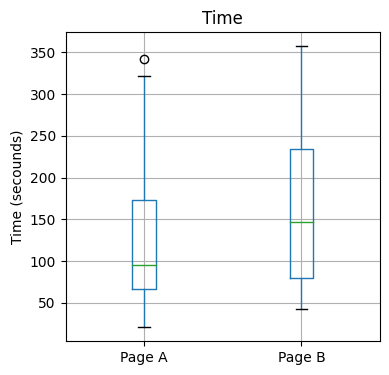

In [5]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (secounds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [6]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(f"Mean time of Page A: {mean_a}")
print(f"Mean time of Page B: {mean_b}")
print(f"Difference between mean times: {mean_b - mean_a}")

Mean time of Page A: 126.33333333333333
Mean time of Page B: 162.0
Difference between mean times: 35.66666666666667


Permutation test - to check if difference is due to randomness

In [15]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB)) # example print

-36.1047619047619


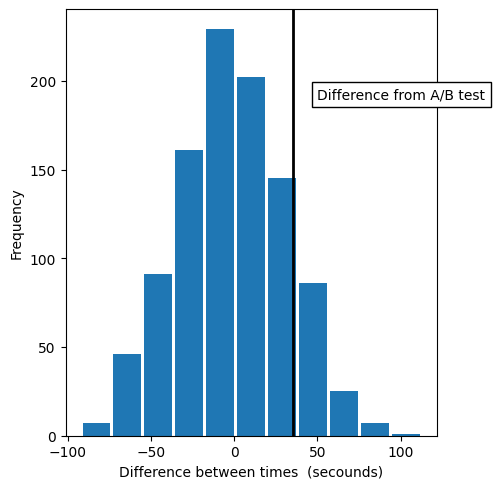

In [17]:
random.seed(32)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)] # we need to generate 1000 samples in order to look at distribution

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = (mean_b - mean_a), color='black', lw=2)
ax.text(50, 190, 'Difference from A/B test', bbox={'facecolor':'white'})
ax.set_xlabel('Difference between times  (secounds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
print("Mean difference above difference from A/B test:")
print(f"{round(np.mean(perm_diffs > (mean_b - mean_a))*100,2)}%")

Mean difference above difference from A/B test:
13.7%


That means our difference is in range of random variation. <b>Which is not statistically significant</b>

### Statistical significance and p-values

Values we are going to use to test it:
| Result   | Price A | Price B |
|----------|---------|---------|
| Sale     | 200     | 182     |
| Not Sale | 23539   | 22406   |

In [25]:
random.seed(1)
difference = (200 / 23739 - 182 / 22588)*100
print(f'Difference: {difference:.4f}%')

Difference: 0.0368%


We make series with real numbers of zeros (not sale) and ones (sale)

In [26]:
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
conversion

0        0
1        0
2        0
3        0
4        0
        ..
46322    1
46323    1
46324    1
46325    1
46326    1
Length: 46327, dtype: int64

1000 iterations of random sampling 

In [28]:
perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

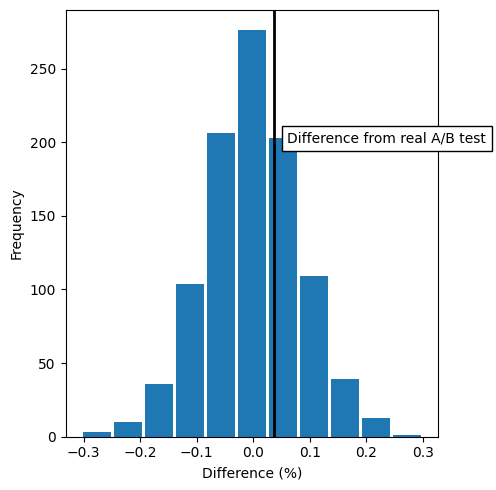

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=difference, color='black', lw=2)
ax.text(0.06, 200, 'Difference from real A/B test', bbox={'facecolor':'white'})
ax.set_xlabel('Difference (%)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
print(np.mean([diff > difference for diff in perm_diffs])) # percent of Trues

0.331


In [32]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value one-tailed test: {p_value / 2:.4f}')

p-value one-tailed test: 0.3498


That means our difference is in range of random variation. <b>Which is not statistically significant</b>

### Test T - alternative for permutation test

In [33]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value one-tailed test: {res.pvalue / 2:.4f}')

p-value one-tailed test: 0.1408


In [34]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


### ANOVA - for tests like A/B/C/D etc

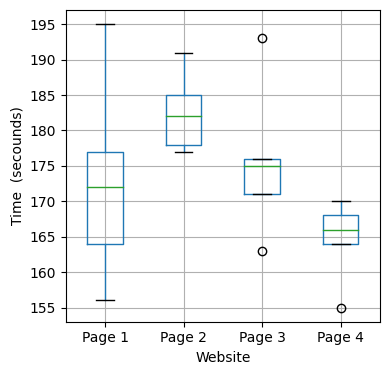

In [35]:
four_sessions = pd.read_csv(r'data\four_sessions.csv')

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Website')
ax.set_ylabel('Time  (secounds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [36]:
four_sessions.head(5)

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [37]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Przykład testu permutacyjnego
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
40.59999999999989


p-value 0.08233333333333333


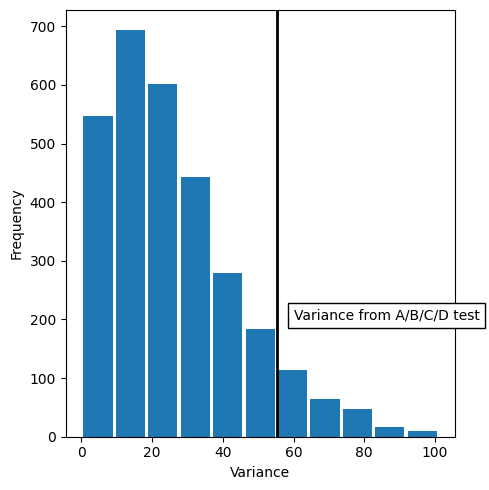

In [39]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('p-value', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Variance from A/B/C/D test', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

That means our variance is in range of random variation. <b>Which is not statistically significant</b>

### Test F - alternative for ANOVA

In [40]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [42]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'Statistic F: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

Statistic F: 1.3699
p-value: 0.0388


### Test Chi-square

In [51]:
click_rate = pd.read_csv(r'data\click_rates.csv')
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [50]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [49]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'chi2 value: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

chi2 value: 1.6659
p-value: 0.4348


### Power and sample size

In [56]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample size: %.3f' % result)

Sample size: 116602.391


In [57]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample size: %.3f' % result)

Sample size: 5488.408
